In [1]:
import torch
import gpytorch
from matplotlib import pyplot as plt
import math
import numpy as np
import pandas as pd
import tqdm.notebook
import time
from sklearn import preprocessing
import glob
from skimage.measure import block_reduce
import tqdm.notebook
from datetime import datetime
import gc

%matplotlib inline
%load_ext autoreload
%autoreload 2
plt.style.use('classic')
import src.utils
from src.utils import set_gpytorch_settings
set_gpytorch_settings(False)
# Kernel Imports
from gpytorch.kernels import PeriodicKernel
from src.custom_kernel import MinKernel, AR2Kernel, MaternKernel, LinearKernel
from gpytorch.kernels import ScaleKernel, RBFKernel, InducingPointKernel
from gpytorch.kernels.keops import MaternKernel as FastMaternKernel
from gpytorch.kernels.keops import RBFKernel as FastRBFKernel
from gpytorch.means import ConstantMean
from gpytorch.distributions import MultivariateNormal
from gpytorch.constraints import Interval
import itertools
# from gpytorch.metrics import mean_standardized_log_loss, quantile_coverage_error, mean_squared_error, mean_absolute_error
from src.custom_kernel import noise_lower, noise_upper, noise_init

['/home/dcaos/PycharmProjects/GaussProcesses/notebooks', '/home/dcaos/PycharmProjects/GaussProcesses', '/home/dcaos/anaconda3/lib/python310.zip', '/home/dcaos/anaconda3/lib/python3.10', '/home/dcaos/anaconda3/lib/python3.10/lib-dynload', '', '/home/dcaos/.local/lib/python3.10/site-packages', '/home/dcaos/anaconda3/lib/python3.10/site-packages', '/home/dcaos/anaconda3/lib/python3.10/site-packages/PyQt5_sip-12.11.0-py3.10-linux-x86_64.egg', '/home/dcaos/anaconda3/lib/python3.10/site-packages/mpmath-1.2.1-py3.10.egg', '/home/dcaos/PycharmProjects/GaussProcesses']


In [2]:
# Reading data file and cleaning missing values
df = pd.read_feather('../Data/feather/46221_9999_wave_height.feather')
parameters_wave = ['time', 'wave_height']
parameters_temp = ['time', 'sea_surface_temperature']
df_as_np = df \
    .loc[:, parameters_wave] \
    .astype(float) \
    .replace(to_replace = [999.0, 99.0, 9999.0], value = np.nan) \
    .to_numpy()
using_sk = block_reduce(df_as_np, block_size=(24,1), func=np.mean).astype(float)
X = torch.tensor(using_sk[:-1,0]).float().cuda()
y = torch.tensor(using_sk[:-1,1]).float().cuda()
X = X.reshape(-1,1)
y = y.reshape(-1,1)

X = X[~torch.any(y.isnan(), dim=1)]
y = y[~torch.any(y.isnan(), dim=1)]
y = y.flatten()
X_old = X


In [3]:
# Helper functions
def period_print(x, scale_factor_value):
    print(f"raw: {x}")
    print(f"seconds: {x * scale_factor_value}")
    print(f"minutes: {x * scale_factor_value / 60}")
    print(f"hours: {x * scale_factor_value / 60 / 60 }")
    print(f"days: {x * scale_factor_value / 60 / 60 / 24}")
    print(f"weeks: {x * scale_factor_value / 60 / 60 / 24 / 7}")
    print(f"months: {x * scale_factor_value / 60 / 60 / 24 / 30}")
    print(f"years: {x * scale_factor_value / 60 / 60 / 24 / 365}")

def period_convert(x, type_to_convert, scale_factor_val):
    match type_to_convert:
        case "raw":
            return x
        case "seconds":
            return x * scale_factor_val
        case "minutes":
            return x * scale_factor_val / 60
        case "hours":
            return x * scale_factor_val / 60 / 60
        case "days":
            return x * scale_factor_val / 60 / 60 / 24
        case "weeks":
            return x * scale_factor_val / 60 / 60 / 24 / 7
        case "months":
            return x * scale_factor_val / 60 / 60 / 24 / 30
        case "years":
            return x * scale_factor_val / 60 / 60 / 24 / 365

def period_convert_list(li, type_to_convert, scale_factor_val):
    converted_list = []
    for h in li:
        converted_list.append(period_convert(h, type_to_convert, scale_factor_val))
    return converted_list

def scaler(a, X_old=X_old, center=True):
    if center is True:
        a = a - X_old.min(0).values
    return a / (X_old.max(0).values - X_old.min(0).values)

def make_kernel(name_of_kernel):
    if name_of_kernel == 'RBF':
        return RBFKernel()
    if name_of_kernel.startswith('Mat'):
        nu_value = float(name_of_kernel[-3:])
        return MaternKernel(nu=nu_value)
    if name_of_kernel == 'AR2':
        return AR2Kernel(
            period_constraint=Interval(
                lower_bound=1e-4, upper_bound=0.005),
            lengthscale_constraint=Interval(
                lower_bound=1e-4, upper_bound=0.005))
    if name_of_kernel.startswith('Per'):
        if name_of_kernel.startswith('Per_Arb'):
            return PeriodicKernel()
                # period_length_constraint=Interval(
                #     lower_bound=1e-4, upper_bound=0.75))
        elif name_of_kernel == 'Per_Week':
            return PeriodicKernel(
                period_length_constraint=Interval(
                    lower_bound=1e-4, upper_bound=0.75,
                initial_value=scaler(60*60*24*7, center=False)))
        elif name_of_kernel == 'Per_Month':
            return PeriodicKernel(
                period_length_constraint=Interval(
                    lower_bound=1e-4, upper_bound=0.75,
                initial_value=scaler(60*60*24*30, center=False)))
    else:
        raise ValueError('Kernel not found')

def descaler(a, X_old=X_old, center=True):
    if center is True:
        a = a * (X_old.max(0).values - X_old.min(0).values)
    return a + X_old.min(0).values

# GP Model Declaration
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, kernel):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = kernel

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)



Scale Max: 1677108352.0
 Scale Min: 1349069952.0
 Scale Factor: 328038400.0
Before Block Reduce: (174818, 2)
After Block Reduce: (7285, 2)
Number of Nans: 0
Start Time: 2012-09-30 16:55:44
End Time: 2023-02-22 23:25:52
Number of Days: 3642.0416666666665
Time Period (Days): 3797.312592592593


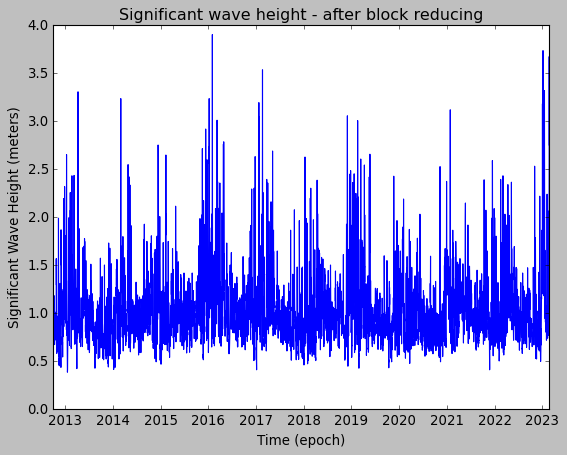

In [4]:
from numpy.ma import indices

# Scale the time axis and log transform the Y-values
X = scaler(X, X_old)
y = y.log()

# max, min, and scale factor declaration
scaler_max = X_old.max(0).values.item()
scaler_min = X_old.min(0).values.item()
scale_factor = scaler_max - scaler_min
print(f'Scale Max: {scaler_max}\n Scale Min: {scaler_min}\n Scale Factor: {scale_factor}')
temp_for_plotting = pd.Series(using_sk[:-1,0]*1e9, dtype='datetime64[ns]')
plt.plot(temp_for_plotting, using_sk[:-1,1])
# plt.plot(y.cpu().numpy())
# print(y)
plt.xlabel("Time (epoch)")
plt.ylabel("Significant Wave Height (meters)")
plt.title(f'Significant wave height - after block reducing')

print(
    f'Before Block Reduce: {df_as_np.shape}\n'
    f'After Block Reduce: {using_sk.shape}\n'
    f'Number of Nans: {np.count_nonzero(np.isnan(df_as_np))}\n'
    f'Start Time: {datetime.fromtimestamp(df_as_np[0,0])}\n'
    f'End Time: {datetime.fromtimestamp(df_as_np[-1,0])}\n'
    f'Number of Days: {df_as_np.shape[0]/48}\n'
    f'Time Period (Days): {(df_as_np[-1,0] - df_as_np[0,0]) / 24 / 60 / 60}')

# Prediction range, training and test set define
predict_days_out = 14
test_n = 2*predict_days_out
train_x = X[test_n:].contiguous().cuda()
train_y = y[test_n:].contiguous().cuda()
test_x = X[-test_n:].contiguous().cuda()
test_y = y[-test_n:].contiguous().cuda()

# Generate the train_loader and train_dataset
train_loader, train_dataset, test_loader, test_dataset = src.utils.create_train_loader_and_dataset(
    train_x, train_y, test_x, test_y)
data_compact = [train_x, train_y, test_x, test_y, train_loader, train_dataset, test_loader, test_dataset]

In [5]:
# List of possible Kernels terms
# Long-term dependence
smooth_kernel_list_t1 = ['RBF']#'', '', '', '']#, 'Mat0.5', 'Mat1.5', 'Mat2.5']
# Medium-term dependence
smooth_kernel_list_t2 = ['Mat2.5']#, 'Mat2.5']#['RBF', 'Mat0.5', 'Mat1.5',
# Fixed Monthly Period
periodic_kernel_list_t3 = ['Per_Month']
# Cyclic period
smooth_kernel_list_t4 = ['RBF']#, 'Mat0.5', 'Mat1.5', 'Mat2.5']
periodic_kernel_list_t4 = ['Per_Arb']#['Per_Arb', 'Per_Week',

periodic_kernel_list_tn = ['RBF', 'Per_Arb', 'Per_Arb', 'Per_Arb', 'Per_Arb', 'Per_Arb','', '', '', '', '', '', '']

baseline_kernel_list = []
for i in itertools.product(*[smooth_kernel_list_t1, smooth_kernel_list_t2, periodic_kernel_list_t3, periodic_kernel_list_t4, smooth_kernel_list_t4]):
    baseline_kernel_list.append(i)

n_kernel_list = []
for i in itertools.combinations(periodic_kernel_list_tn, r=6):
    n_kernel_list.append(i)
n_k_l = list(pd.DataFrame(n_kernel_list).drop_duplicates(keep='first').iloc[:6, :].itertuples(index=False, name=None))
n_k_l.reverse()
# print(n_k_l)

[('RBF', '', '', '', '', ''), ('RBF', 'Per_Arb', '', '', '', ''), ('RBF', 'Per_Arb', 'Per_Arb', '', '', ''), ('RBF', 'Per_Arb', 'Per_Arb', 'Per_Arb', '', ''), ('RBF', 'Per_Arb', 'Per_Arb', 'Per_Arb', 'Per_Arb', ''), ('RBF', 'Per_Arb', 'Per_Arb', 'Per_Arb', 'Per_Arb', 'Per_Arb')]


Using available CUDA


Training_exactGP0:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 00072: reducing learning rate of group 0 to 1.0000e-02.
Epoch 00078: reducing learning rate of group 0 to 1.0000e-03.
Epoch 00084: reducing learning rate of group 0 to 1.0000e-04.
Epoch 00090: reducing learning rate of group 0 to 1.0000e-05.
Epoch 00096: reducing learning rate of group 0 to 1.0000e-06.
Epoch 00102: reducing learning rate of group 0 to 1.0000e-07.
Epoch 00108: reducing learning rate of group 0 to 1.0000e-08.
0
Learning Rate:  0.1
Kernel Structure:  RBF     
BIC:  nan
Iterations Number(n):  0
Hyper Values:  [[-9999]]
Output Scale Values:  [[nan]]
Memory Check:  (9211215872, 12584026112)
Using available CUDA


Training_exactGP1:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 00093: reducing learning rate of group 0 to 1.0000e-02.
Epoch 00099: reducing learning rate of group 0 to 1.0000e-03.
Epoch 00105: reducing learning rate of group 0 to 1.0000e-04.
Epoch 00111: reducing learning rate of group 0 to 1.0000e-05.
Epoch 00117: reducing learning rate of group 0 to 1.0000e-06.
Epoch 00123: reducing learning rate of group 0 to 1.0000e-07.
Epoch 00129: reducing learning rate of group 0 to 1.0000e-08.
0
1
Learning Rate:  0.1
Kernel Structure:  RBF Per_Arb    
BIC:  nan
Iterations Number(n):  1
Hyper Values:  [[-9999], [nan]]
Output Scale Values:  [[nan], [nan]]
Memory Check:  (7479033856, 12584026112)
Using available CUDA


Training_exactGP2:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 00077: reducing learning rate of group 0 to 1.0000e-02.
Epoch 00083: reducing learning rate of group 0 to 1.0000e-03.
Epoch 00089: reducing learning rate of group 0 to 1.0000e-04.
Epoch 00095: reducing learning rate of group 0 to 1.0000e-05.
Epoch 00101: reducing learning rate of group 0 to 1.0000e-06.
Epoch 00107: reducing learning rate of group 0 to 1.0000e-07.
Epoch 00113: reducing learning rate of group 0 to 1.0000e-08.
0
1
2
Learning Rate:  0.1
Kernel Structure:  RBF Per_Arb Per_Arb   
BIC:  1080.1832275390625
Iterations Number(n):  2
Hyper Values:  [[-9999], [0.4656672477722168], [0.4656672477722168]]
Output Scale Values:  [[0.0637865886092186], [0.017306439578533173], [0.017306439578533173]]
Memory Check:  (6288179200, 12584026112)
Using available CUDA


Training_exactGP3:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 00078: reducing learning rate of group 0 to 1.0000e-02.
Epoch 00092: reducing learning rate of group 0 to 1.0000e-03.
Epoch 00098: reducing learning rate of group 0 to 1.0000e-04.
Epoch 00104: reducing learning rate of group 0 to 1.0000e-05.
Epoch 00110: reducing learning rate of group 0 to 1.0000e-06.
Epoch 00116: reducing learning rate of group 0 to 1.0000e-07.
Epoch 00122: reducing learning rate of group 0 to 1.0000e-08.
0
1
2
3
Learning Rate:  0.1
Kernel Structure:  RBF Per_Arb Per_Arb Per_Arb  
BIC:  862.9473266601562
Iterations Number(n):  3
Hyper Values:  [[-9999], [0.5669214725494385], [0.5669214725494385], [0.5669214725494385]]
Output Scale Values:  [[0.04229928180575371], [0.01316111721098423], [0.01316111721098423], [0.01316111721098423]]
Memory Check:  (5174722560, 12584026112)
Using available CUDA


Training_exactGP4:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 00048: reducing learning rate of group 0 to 1.0000e-02.
Epoch 00054: reducing learning rate of group 0 to 1.0000e-03.
Epoch 00060: reducing learning rate of group 0 to 1.0000e-04.
Epoch 00066: reducing learning rate of group 0 to 1.0000e-05.
Epoch 00072: reducing learning rate of group 0 to 1.0000e-06.
Epoch 00078: reducing learning rate of group 0 to 1.0000e-07.
Epoch 00084: reducing learning rate of group 0 to 1.0000e-08.
0
1
2
3
4
Learning Rate:  0.1
Kernel Structure:  RBF Per_Arb Per_Arb Per_Arb Per_Arb 
BIC:  1638.43701171875
Iterations Number(n):  4
Hyper Values:  [[-9999], [0.7377966642379761], [0.7377966642379761], [0.7377966642379761], [0.7377966642379761]]
Output Scale Values:  [[0.02344592474400997], [0.0059044514782726765], [0.0059044514782726765], [0.0059044514782726765], [0.0059044514782726765]]
Memory Check:  (3798138880, 12584026112)
Using available CUDA


Training_exactGP5:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 00091: reducing learning rate of group 0 to 1.0000e-02.
Epoch 00097: reducing learning rate of group 0 to 1.0000e-03.
Epoch 00103: reducing learning rate of group 0 to 1.0000e-04.
Epoch 00109: reducing learning rate of group 0 to 1.0000e-05.
Epoch 00115: reducing learning rate of group 0 to 1.0000e-06.
Epoch 00121: reducing learning rate of group 0 to 1.0000e-07.
Epoch 00127: reducing learning rate of group 0 to 1.0000e-08.
0
1
2
3
4
5
Learning Rate:  0.1
Kernel Structure:  RBF Per_Arb Per_Arb Per_Arb Per_Arb Per_Arb
BIC:  -1906.1807861328125
Iterations Number(n):  5
Hyper Values:  [[-9999], [2.0027830600738525], [2.0027830600738525], [2.0027830600738525], [2.0027830600738525], [2.0027830600738525]]
Output Scale Values:  [[0.003278512740507722], [0.011813066899776459], [0.011813066899776459], [0.011813066899776459], [0.011813066899776459], [0.011813066899776459]]
Memory Check:  (3068461056, 12584026112)


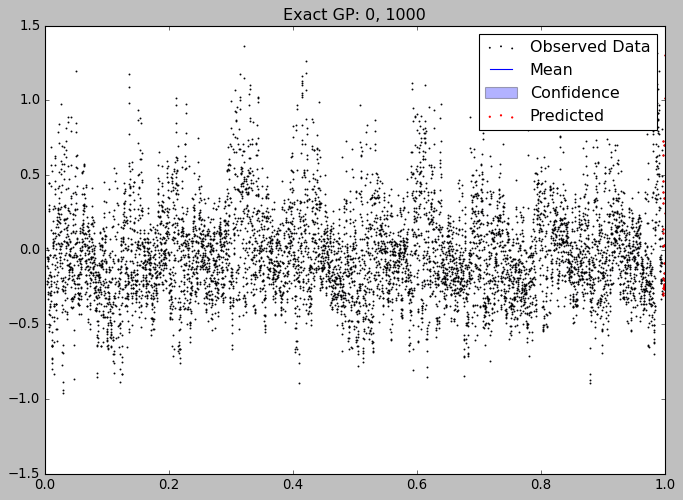

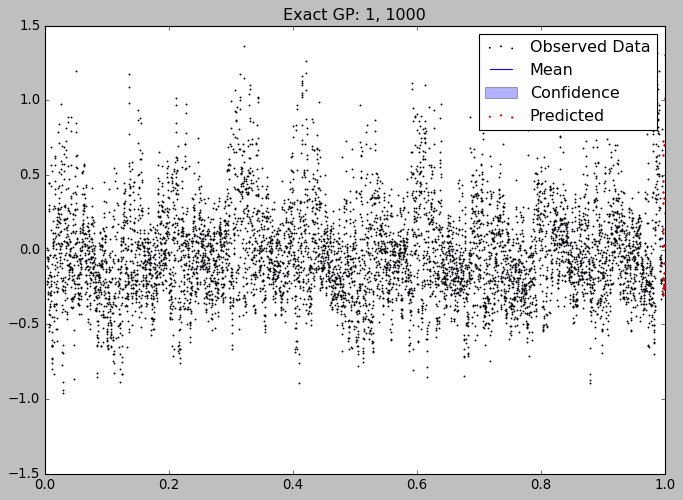

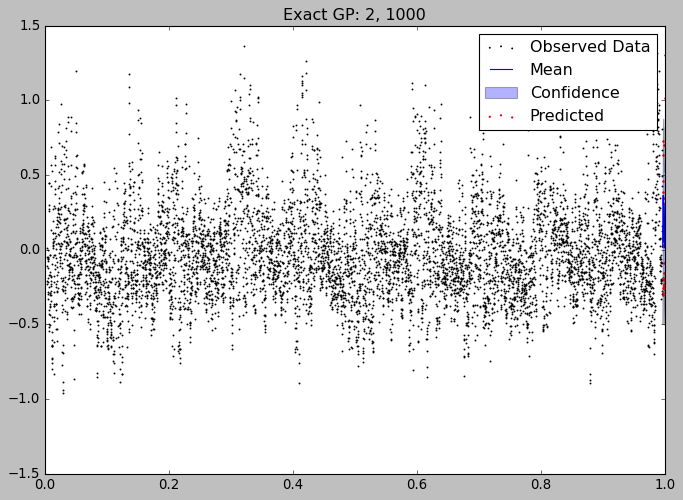

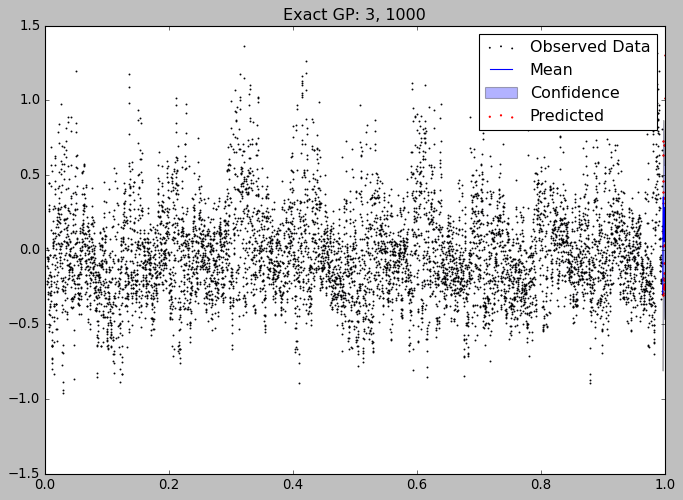

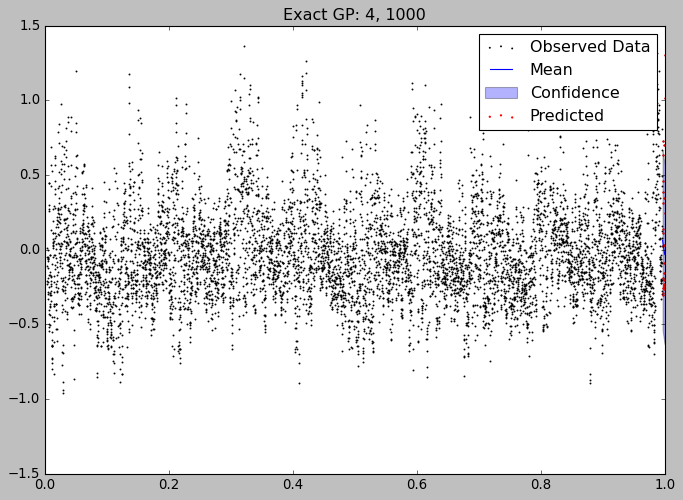

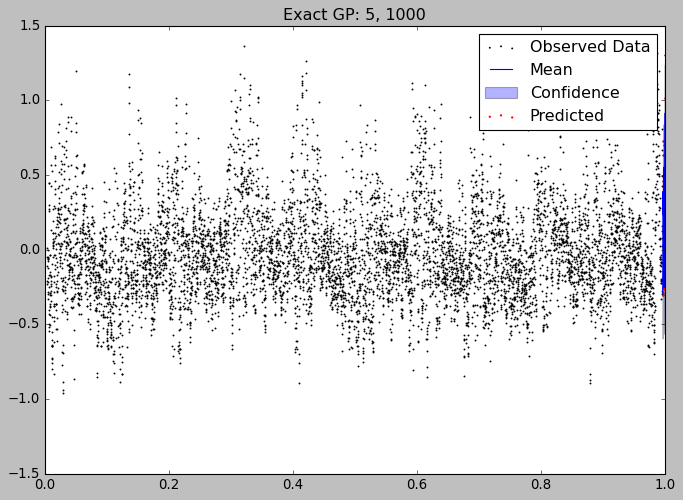

In [6]:
# Initializing empty list to record values
bic_save = []
n = 0
lr_check = 0.01#0.0063
for k_i in n_k_l:
    kernel = ScaleKernel(make_kernel(k_i[0]))
    for t_i in list(k_i)[1:]:
        if t_i == '':
            break
        kernel = kernel + (ScaleKernel(make_kernel(t_i)))
    # sk1, sk2, pk1, pk2, sk3 = k_i
    # kernel = ScaleKernel(make_kernel(sk1)) + ScaleKernel(make_kernel(sk2)) + ScaleKernel(make_kernel(pk1)) + ScaleKernel(make_kernel(pk2) * make_kernel(sk3))
    # kernel_name = f'{sk1}plus{sk2}plus{pk1}plus{sk3}x{pk2}_exact_gp'
    # k_list = [str(sk1), str(sk2), str(pk1), str(pk2), str(sk3)]
    kernel_name = str(n)
    exact_gp = src.utils.TrainTestPlotSaveExactGP(
        ExactGPModel, kernel,
        train_x, train_y, test_x, test_y,
        num_iter=1000, lr=lr_check, #lr=0.0063, #lr=0.01,
        name=kernel_name)
    exact_gp.test_eval_exact_gp()
    exact_gp.plot(show_plot=False)
    bic_value = exact_gp.get_BIC()
    hyper_values = []
    output_scale = []
    if n == 0:
        output_scale.append([kernel.outputscale.item()])
    else:
        output_scale.append([kernel.kernels[0].outputscale.item()])
    for pk in range(n+1):
        print(pk)
        if pk == 0:
            hyper_values.append([-9999])
        else:
            hyper_values.append([kernel.kernels[pk].base_kernel.period_length.item()])
            output_scale.append([kernel.kernels[pk].outputscale.item()])


        # kernel.kernels[0].base_kernel.lengthscale.item(),
        # kernel.kernels[1].base_kernel.lengthscale.item(),
        # kernel.kernels[2].base_kernel.lengthscale.item(),
        # kernel.kernels[2].base_kernel.period_length.item(),
        # kernel.kernels[3].base_kernel.kernels[0].lengthscale.item(),
        # kernel.kernels[3].base_kernel.kernels[0].period_length.item(),
        # kernel.kernels[3].base_kernel.kernels[1].lengthscale.item(),]
    bic_save.append([
        kernel_name,
        n,
        bic_value.item(),
        hyper_values,
        output_scale,
        kernel])
        #period_convert_list(hyper_values, "days", scale_factor),])
        # *hyper_values,
        # *k_i])
    print("Learning Rate: ", lr_check)
    print("Kernel Structure: ", *k_i)
    print("BIC: ", exact_gp.get_BIC().item())
    print("Iterations Number(n): ",n)
    print("Hyper Values: ", hyper_values)
    print("Output Scale Values: ", output_scale)
    print("Memory Check: ", torch.cuda.mem_get_info(device=None))
    n += 1
    # lr_check += 0.0001
    del exact_gp
    del kernel
    gc.enable()
    gc.collect()
    torch.cuda.empty_cache()
column_names = [
        'Kernel_Name','n', 'BIC', 'Period_Length_(days)', 'Output_Scale', 'kernel_full']
        # 's1_ls_converted', 's2_ls_converted','pk1_ls_converted', 'pk1_pr_converted', 'pk2_ls_converted', 'pk2_pr_converted', 's3_ls_converted',
        # 's1_ls_raw', 's2_ls_raw', 'pk1_ls_raw', 'pk1_pr_raw', 'pk2_ls_raw', 'pk2_pr_raw','s3_ls_raw',
        # 'add_scale1_K1', 'add_scale2_K2', 'add_period1_K3', 'scale3_mult_K4', 'scale3_mult_K4']
bic_out_df = pd.DataFrame(
    bic_save, columns=column_names)
bic_out_df.to_csv('bic_save_linear_kernel_struct_baseline.csv')

In [7]:

bic_out_df.to_csv("additive_kernel_failed_repeating_kernel_value.csv")
#bic_out_df["kernel_full"][3].kernels
bic_out_df

,Kernel_Name,n,BIC,Period_Length_(days),Output_Scale,kernel_full
0,0,0,NaN,[[-9999]],[[nan]],ScaleKernel(\n (base_kernel): RBFKernel(\n ...
1,1,1,NaN,"[[-9999], [nan]]","[[nan], [nan]]",AdditiveKernel(\n (kernels): ModuleList(\n ...
2,2,2,1080.183228,"[[-9999], [0.4656672477722168], [0.46566724777...","[[0.0637865886092186], [0.017306439578533173],...",AdditiveKernel(\n (kernels): ModuleList(\n ...
3,3,3,862.947327,"[[-9999], [0.5669214725494385], [0.56692147254...","[[0.04229928180575371], [0.01316111721098423],...",AdditiveKernel(\n (kernels): ModuleList(\n ...
4,4,4,1638.437012,"[[-9999], [0.7377966642379761], [0.73779666423...","[[0.02344592474400997], [0.0059044514782726765...",AdditiveKernel(\n (kernels): ModuleList(\n ...
5,5,5,-1906.180786,"[[-9999], [2.0027830600738525], [2.00278306007...","[[0.003278512740507722], [0.011813066899776459...",AdditiveKernel(\n (kernels): ModuleList(\n ...


In [10]:
bic_out_df.iloc[:, 2:-1].to_latex()



/tmp/ipykernel_22201/1239213253.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  bic_out_df.iloc[:, :-1].to_latex()


'\\begin{tabular}{llrrll}\n\\toprule\n{} & Kernel\\_Name &  n &          BIC &                               Period\\_Length\\_(days) &                                       Output\\_Scale \\\\\n\\midrule\n0 &           0 &  0 &          NaN &                                          [[-9999]] &                                            [[nan]] \\\\\n1 &           1 &  1 &          NaN &                                   [[-9999], [nan]] &                                     [[nan], [nan]] \\\\\n2 &           2 &  2 &  1080.183228 &  [[-9999], [0.4656672477722168], [0.46566724777... &  [[0.0637865886092186], [0.017306439578533173],... \\\\\n3 &           3 &  3 &   862.947327 &  [[-9999], [0.5669214725494385], [0.56692147254... &  [[0.04229928180575371], [0.01316111721098423],... \\\\\n4 &           4 &  4 &  1638.437012 &  [[-9999], [0.7377966642379761], [0.73779666423... &  [[0.02344592474400997], [0.0059044514782726765... \\\\\n5 &           5 &  5 & -1906.180786 &  [[-9999], [2.00

In [8]:
# print(len(bic_save[0]))
# bic_save
# gc.enable()
# gc.collect()
# torch.cuda.empty_cache()
# torch.cuda.CUDAGraph().pool()

# baseline_df_master = pd.read_csv('Baseline_Kernel_Results.csv', index_col='BIC')
# baseline_df_master.to_csv('Baseline_Kernel_Results_bak.csv')
# # baseline_df_master = baseline_df_master.reset_index()
# baseline_df_master



# joined_baseline_df = pd.merge(right=baseline_df_master, left=bic_out_df, on='BIC', how='outer')
# pd.concat([baseline_df_master, bic_out_df], ignore_index=True)
# joined_baseline_df.to_csv('Baseline_Kernel_Results.csv')
# joined_baseline_df
# temp_list = []
# temp_list.append([*period_convert_list(hyper_values, "days", scale_factor)])
# temp_list


# print(bic_out_df["kernel_full"][3].kernels[0].outputscale.item(),
#     bic_out_df["kernel_full"][3].kernels[1].outputscale.item(),
#     bic_out_df["kernel_full"][3].kernels[2].outputscale.item(),
#     bic_out_df["kernel_full"][3].kernels[2].outputscale.item(),)
# print(bic_out_df["kernel_full"][3].kernels[0].outputscale.item()+bic_out_df["kernel_full"][3].kernels[2].outputscale.item())



# kernel.outputscale
# kernel.kernels[2].base_kernel.lengthscale.item(),

# for i in itertools.accumulate(periodic_kernel_list_tn, operator.add):
#     print(i)
# l1 = (['abc', 'def'])
# l2 = ['123', '456']
# l3 = ['---', 'xxx']
# list_of_lists = [l1, l2, l3]
# l4 = np.array([['rbf']])
# # for i in itertools.product(zip(smooth_kernel_list_t1, smooth_kernel_list_t2, periodic_kernel_list_t3, smooth_kernel_list_t4, periodic_kernel_list_t4)):
# for i in itertools.product(*[l1, l2, l3]):#*zip(l1, l2, l3)):
# # for i in itertools.product(*[smooth_kernel_list_t1, smooth_kernel_list_t2, periodic_kernel_list_t3, smooth_kernel_list_t4, periodic_kernel_list_t4]):
#     print(i, ": ")
#     print(i[1])
# # plt.plot(bic_out_df['BIC'])
# # vector_i = np.array([[1, 1, 1, 0]]).T
# # [a*b for a,b in zip(vector_i, l4)]
# # np.dot(vector_i, l4)
# kernel

# two_term_results = pd.read_csv("joined_results_4_7.csv")
# merged_df = pd.merge(bic_out_df, two_term_results, how="outer")
# merged_df.to_csv('merged_csv_messy.csv')
# merged_df

# kernel
# torch.cuda.current_device()

ModuleList(
  (0): ScaleKernel(
    (base_kernel): RBFKernel(
      (raw_lengthscale_constraint): Positive()
    )
    (raw_outputscale_constraint): Positive()
  )
  (1-3): 3 x ScaleKernel(
    (base_kernel): PeriodicKernel(
      (raw_lengthscale_constraint): Positive()
      (raw_period_length_constraint): Positive()
    )
    (raw_outputscale_constraint): Positive()
  )
)